In [52]:
import pandas as pd 
from fastai.tabular.all import *

In [53]:
data = pd.read_parquet('transactions_cleaned.parquet')
data['Day'] = data['Order_Date_FK'].dt.day.astype(int)
data['Month'] = data['Order_Date_FK'].dt.month.astype(int)
data['Weekday'] = data['Order_Date_FK'].dt.weekday.astype(int)
data['Webshop'] = data['Shop'].apply(lambda x: 1 if len(x) > 2 else 0)

data.drop(columns=['Shop','Order_Date_FK'], inplace=True)

In [54]:
train=data.sample(frac=0.80, random_state=42).reset_index(drop=True)
val = data.drop(train.index).reset_index(drop=True)

In [55]:
# Determine the counts of each value in the 'returned' column
returned_counts = train['Returned'].value_counts()

# Find the minimum count between 0 and 1 values
min_count = min(returned_counts[0], returned_counts[1])

# Downsample the data to get equal counts for 0 and 1 values
data_downsampled = pd.concat([
    train[train['Returned'] == '0'].sample(n=min_count*3, random_state=42),
    train[train['Returned'] == '1'].sample(n=min_count, random_state=42)
])

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


In [56]:
splits = RandomSplitter(valid_pct=0.2)(range_of(data_downsampled)) # Same as Train-Test Split in sklearn
to = TabularPandas(data_downsampled, procs=[Categorify, FillMissing,Normalize],
                   cat_names = ['Webshop','ProductCode','CustomerID','SaleDocumentNumber','BrandName','ModelGroup','ProductGroup'],
                   cont_names = ['OriginalSaleAmountInclVAT','RevenueInclVAT', 'CostPriceExclVAT','Day','Month','Weekday'],
                   y_names='Returned',
                   splits=splits)

In [57]:
dls = to.dataloaders(bs=1024)

In [13]:
tab_learn = tabular_learner(dls, metrics=[accuracy, error_rate, Recall(), Precision()])

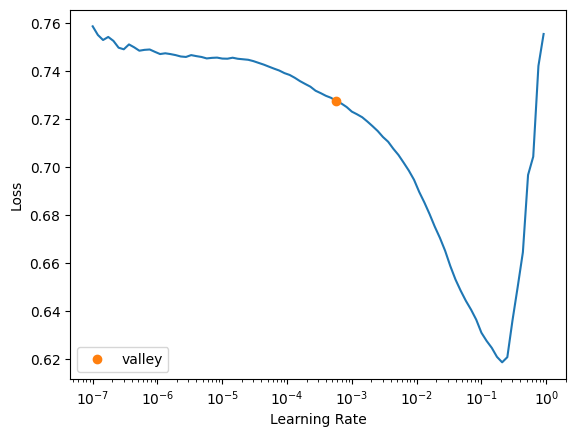

In [61]:
lr = tab_learn.lr_find()

In [62]:
tab_learn.fit_one_cycle(2, lr_max= lr.valley)

epoch,train_loss,valid_loss,accuracy,error_rate,recall_score,precision_score,time
0,0.458417,0.375063,0.868011,0.131989,0.676705,0.766558,00:22
1,0.113552,0.366870,0.875682,0.124318,0.696349,0.781266,00:28


In [63]:
tab_learn.export('tabular_model')

In [64]:
inf = load_learner('tabular_model')

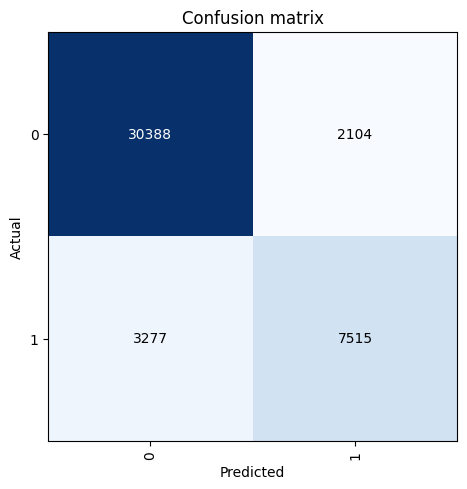

In [65]:
interpret = ClassificationInterpretation.from_learner(tab_learn)
interpret.plot_confusion_matrix()

In [66]:
interpret.print_classification_report()

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     32492
           1       0.78      0.70      0.74     10792

    accuracy                           0.88     43284
   macro avg       0.84      0.82      0.83     43284
weighted avg       0.87      0.88      0.87     43284



In [100]:
interpret.losses

TensorBase([0.0220, 0.0166, 0.1298,  ..., 1.8724, 0.2425, 0.0719])

In [67]:
# Drop the 'Returned' column from val and store it in valX
valX = val.drop(columns=['Returned'])
valY = val['Returned'].to_frame()

In [68]:
dl = inf.dls.test_dl(valX, bs=1024)
preds,  _ = inf.get_preds(dl=dl)
print(len(preds))
print(preds[0])
preds2 = [0 if pred[0] > pred[1] else 1 for pred in preds]
print(preds2[0])

351978
tensor([0.9563, 0.0437])
0


In [69]:
from sklearn.metrics import classification_report
print(classification_report(valY['Returned'].astype('int'), preds2))

              precision    recall  f1-score   support

           0       0.99      0.81      0.89    319873
           1       0.32      0.89      0.47     32105

    accuracy                           0.81    351978
   macro avg       0.65      0.85      0.68    351978
weighted avg       0.93      0.81      0.85    351978



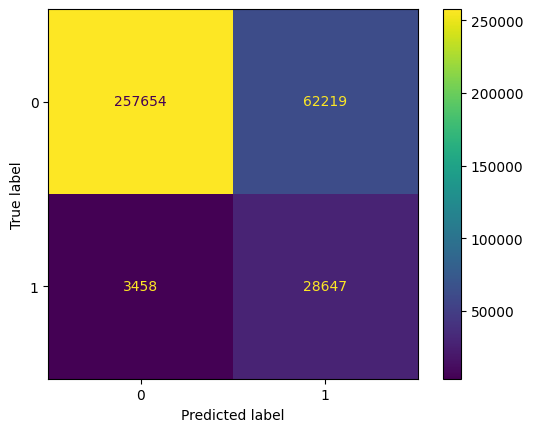

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(valY['Returned'].astype('int'), preds2)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [74]:
tab_learn.summary()

TabularModel (Input shape: 1024 x 7)
Layer (type)         Output Shape         Param #    Trainable 
                     1024 x 3            
Embedding                                 9          True      
____________________________________________________________________________
                     1024 x 361          
Embedding                                 5742066    True      
____________________________________________________________________________
                     1024 x 600          
Embedding                                 75153000   True      
Embedding                                 102617400  True      
____________________________________________________________________________
                     1024 x 54           
Embedding                                 29160      True      
____________________________________________________________________________
                     1024 x 11           
Embedding                                 363        True    

In [93]:
import shap
import torch

In [94]:
# pull a sample of our data (128 images)
batch = dls.one_batch()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# specify how many images to use when creating the background distribution
num_samples = 100
explainer = shap.GradientExplainer(tab_learn.model.to(device), batch[0][:num_samples].to(device))


# calculate shapely values
shap_values = explainer.shap_values(
    batch[0][num_samples:]
)

AttributeError: 'NoneType' object has no attribute 'dim'